In [414]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn import metrics
import pandas_datareader.data as web 
from time import time
from sklearn.cluster import KMeans

# Get Stock Data

In [415]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [416]:
#Select columns
base = stk_data.loc[:, ('Adj Close', 'MSFT')]
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data
print(X1)
print(X2)
print(X2)

Attributes   Adj Close            
Symbols          GOOGL         IBM
Date                              
2017-09-25   46.714001  109.942177
2017-09-26   46.871498  110.462234
2017-09-27   47.994999  109.783890
2017-09-28   48.240501  109.783890
2017-09-29   48.686001  109.346748
...                ...         ...
2022-09-16  102.800003  127.269997
2022-09-19  103.070000  127.730003
2022-09-20  101.139999  126.300003
2022-09-21   99.279999  124.930000
2022-09-22  100.139999  125.309998

[1258 rows x 2 columns]
            DEXJPUS  DEXUSUK
DATE                        
2017-09-25   111.64   1.3457
2017-09-26   112.16   1.3422
2017-09-27   112.76   1.3401
2017-09-28   112.66   1.3435
2017-09-29   112.64   1.3402
...             ...      ...
2022-09-12   142.41   1.1701
2022-09-13   144.30   1.1526
2022-09-14   142.93   1.1564
2022-09-15   143.57   1.1472
2022-09-16   143.04   1.1419

[1300 rows x 2 columns]
            DEXJPUS  DEXUSUK
DATE                        
2017-09-25   111.64   1.3

In [417]:
#Standardized data (X1, X2, X3) with kept index (date)
standard_scaler = preprocessing.StandardScaler()
sX1 = standard_scaler.fit_transform(X1.values)
sX2 = standard_scaler.fit_transform(X2.values)
sX3 = standard_scaler.fit_transform(X3.values)
X1 = pd.DataFrame(index = X1.index,data = sX1,columns=X1.columns)
X2 = pd.DataFrame(index = X2.index,data = sX2,columns=X2.columns)
X3 = pd.DataFrame(index = X3.index,data = sX3,columns=X3.columns)

## Calculate ความแตกต่างของค่า ราคา 'Adj Close', 'MSFT’)ย้อนหลัง backHistory วัน

In [418]:

backHistory = [30, 45, 60, 90, 180, 240] #-> ทดลองหยิบ 3 ค่า 3 รูปแบบ เพื่อดูระยะเวลาการดูค่าข้อมูลย้อนหลงัหลายๆแบบและเปรียบเทียบ MSE
BH1, BH2, BH3 = backHistory[1], backHistory[3], backHistory[4]
return_period = 2
Y = base.shift(-return_period)
X4_BH1 = base.diff( BH1).shift( - BH1)
X4_BH2 = base.diff( BH2).shift( - BH2)
X4_BH3 = base.diff( BH3).shift( - BH3)

X4 = pd.concat([X4_BH1, X4_BH2, X4_BH3], axis=1)
X4.columns = ['MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X4 = pd.DataFrame(standard_scaler.fit_transform(X4.values), index = X4.index,columns=X4.columns)

In [419]:
# Forming Dataset
X = pd.concat([X1, X2, X3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1)
dataset.dropna(inplace=True)
dataset.describe()

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000
mean,165.971046,-0.205567,-0.223126,-0.338575,0.130736,-0.198329,-0.185340,-0.101468,0.126929,0.151355,0.001336
std,73.329605,0.921420,0.874173,0.357050,0.913578,0.932024,0.950729,1.034052,0.889823,0.875896,0.994072
min,69.393150,-1.159659,-3.287446,-1.214892,-2.751596,-1.664437,-2.424575,-1.308869,-3.832301,-3.763462,-3.677681
25%,102.842392,-0.862360,-0.698881,-0.593148,-0.461011,-0.902425,-0.865630,-0.779002,-0.269088,-0.231870,-0.412160
50%,140.505402,-0.647902,-0.249133,-0.326500,0.052543,-0.590820,-0.511267,-0.362019,0.091079,0.087754,0.053586
75%,214.685989,0.139127,0.261193,-0.081964,0.885793,0.416528,0.346992,0.232355,0.532476,0.590201,0.625638
max,340.882782,2.106610,1.897336,0.554088,2.077850,2.055518,1.992947,7.163257,2.577556,2.210592,2.421412


In [420]:
# Assign X, Y (drop datetime index)
Y = pd.DataFrame(dataset[dataset.columns[0]])
X = pd.DataFrame(dataset[dataset.columns[1:]])
print(Y)
print(X)

             Adj Close
                  MSFT
2017-09-25   69.393150
2017-09-26   69.411926
2017-09-27   69.994514
2017-09-28   70.107277
2017-09-29   69.778404
...                ...
2021-12-28  337.117401
2021-12-29  334.136902
2021-12-30  332.577057
2022-01-03  314.326324
2022-01-04  311.842529

[1061 rows x 1 columns]
            (Adj Close, GOOGL)  (Adj Close, IBM)   DEXJPUS   DEXUSUK  \
2017-09-25           -1.159659         -0.510343 -0.028635  0.589904   
2017-09-26           -1.154671         -0.462353  0.039003  0.530386   
2017-09-27           -1.119086         -0.524949  0.117046  0.494676   
2017-09-28           -1.111310         -0.524949  0.104039  0.552493   
2017-09-29           -1.097200         -0.565287  0.101437  0.496376   
...                        ...               ...       ...       ...   
2021-12-28            2.006792          1.143959  0.375889  0.547391   
2021-12-29            2.005779          1.208015  0.404505  0.620513   
2021-12-30            1.9913

In [421]:
X.corr()

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
"(Adj Close, GOOGL)",1.000000,0.486192,0.094845,0.483430,0.982740,0.952258,0.047198,0.040460,-0.059934,-0.370752
"(Adj Close, IBM)",0.486192,1.000000,0.236112,0.588217,0.506262,0.589115,-0.532156,-0.002491,-0.047912,-0.375536
DEXJPUS,0.094845,0.236112,1.000000,0.077120,0.011478,0.057563,-0.407793,-0.287386,-0.428954,-0.575813
DEXUSUK,0.483430,0.588217,0.077120,1.000000,0.486225,0.528740,-0.304232,0.063434,0.026694,-0.199002
SP500,0.982740,0.506262,0.011478,0.486225,1.000000,0.982879,0.002491,0.011353,-0.035838,-0.281078
DJIA,0.952258,0.589115,0.057563,0.528740,0.982879,1.000000,-0.126383,-0.007451,-0.029897,-0.270801
VIXCLS,0.047198,-0.532156,-0.407793,-0.304232,0.002491,-0.126383,1.000000,0.284879,0.338162,0.259857
MSFT_3DT,0.040460,-0.002491,-0.287386,0.063434,0.011353,-0.007451,0.284879,1.000000,0.654932,0.389448
MSFT_6DT,-0.059934,-0.047912,-0.428954,0.026694,-0.035838,-0.029897,0.338162,0.654932,1.000000,0.671268
MSFT_12DT,-0.370752,-0.375536,-0.575813,-0.199002,-0.281078,-0.270801,0.259857,0.389448,0.671268,1.000000


In [422]:
lower = pd.DataFrame(np.tril(X.corr(),-1),columns = X.columns)
to_drop = [column for column in lower.columns if any(lower[column] > 0.9)]
X.drop(columns=to_drop,inplace=True)
to_drop

[('Adj Close', 'GOOGL'), 'SP500']

In [423]:
X

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-09-25,-0.510343,-0.028635,0.589904,-1.525879,-1.185618,0.238229,0.144408,-0.149238
2017-09-26,-0.462353,0.039003,0.530386,-1.528735,-1.190225,0.154571,-0.000609,-0.133561
2017-09-27,-0.524949,0.117046,0.494676,-1.515053,-1.224782,0.167769,0.104621,-0.185041
2017-09-28,-0.524949,0.104039,0.552493,-1.505230,-1.261642,0.171577,0.037872,-0.165506
2017-09-29,-0.565287,0.101437,0.496376,-1.499434,-1.266250,-0.034679,-0.162271,-0.182321
...,...,...,...,...,...,...,...,...
2021-12-28,1.143959,0.375889,0.547391,1.895550,-0.341285,-2.968482,-3.242002,-3.639137
2021-12-29,1.208015,0.404505,0.620513,1.917488,-0.409246,-3.355530,-3.680764,-3.677681
2021-12-30,1.257836,0.430520,0.663026,1.895518,-0.365474,-3.832301,-3.375628,-3.608616
2022-01-03,1.447330,0.443527,0.610310,1.940883,-0.449562,-3.021936,-3.763462,-3.638334


# Train / Test Preparation (try 2 Option)    

In [424]:
from math import ceil, floor
test_size = floor(0.3 * len( X ))
train_size = floor(0.7 * len( X ))
print(f'test size = {test_size}\ntrain size = {train_size}')
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]
# Option #2
# X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X, Y, test_size=0.3, random_state=seed)

test size = 318
train size = 742


# 6.2 GridSearchCV()

In [425]:
# Create Model List
regression = { 'LR': LinearRegression(), 'SVR': SVR(), }
# Create Parameter Dictionary for Linear Regression
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)
print(params_LR)

{'fit_intercept': [True, False], 'normalize': [True, False]}


In [426]:
#Create Parameter Dictionary for SVR
kernel = ['linear', 'rbf', 'poly']
C_list = [10, 100]
ep_list = [0.1, 1, 5]
gamma = [0.01, 0.1]
degree = [2, 3]       #3x2x3x2x2 = 72
params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )

In [427]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR

    grid = GridSearchCV( 
    estimator=model,                        #model
    n_jobs = 8,                             #thread ที่ใช้               
    verbose = 10,                           #ความละเอียดในการเปิด log
    cv = 5,                                 #kfold
    scoring = 'neg_mean_squared_error',     #neg mean - mse
    param_grid = params)                    #parameter ที่ใช้กับ model
    grid_result = grid.fit(X_train, Y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [428]:
# Show Best Parameters for both models
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

Best params:  {'C': 100, 'degree': 2, 'epsilon': 5, 'gamma': 0.1, 'kernel': 'rbf'}
Best score:  -917.7324964932229


## Show Score for each parameter combination for both model

In [429]:
means   = grid_result.cv_results_['mean_test_score']
stds    = grid_result.cv_results_['std_test_score']
params  = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-1230.162543 (1393.159717) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
-1243.509444 (1777.260925) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
-2429.531711 (2353.837019) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
-1230.162543 (1393.159717) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
-1050.336677 (1418.060936) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
-1473.237743 (2000.302015) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
-1214.785206 (1353.699785) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'linear'}
-1231.454092 (1742.899954) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'rbf'}
-2406.875252 (2344.828747) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'poly'}
-1214.785206 (1353.699785) with: {'C': 10, 'degree': 2, 'epsi

## Display Mean, std, params

# 6.3 RandomizedSearchCV()

In [430]:
# Create Model List
regression = { 'LR': LinearRegression(), 'SVR': SVR()}

In [431]:
# Create Parameter Dictionary for Linear Regression
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)

In [432]:
# Create Parameter Dictionary for SVR
kernel = ['linear', 'rbf', 'poly']
C_list = list(np.linspace(0.1, 150, 5, dtype = float))
ep_list = list(np.linspace(0.1, 1, 5, dtype = float))
gamma = list(np.linspace(0.01, 0.1, 5, dtype = float))
degree = [2, 3]
params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )

## Show scatter plot compare y_test vs each model prediction

In [433]:
# import warnings
# warnings.filterwarnings('ignore')

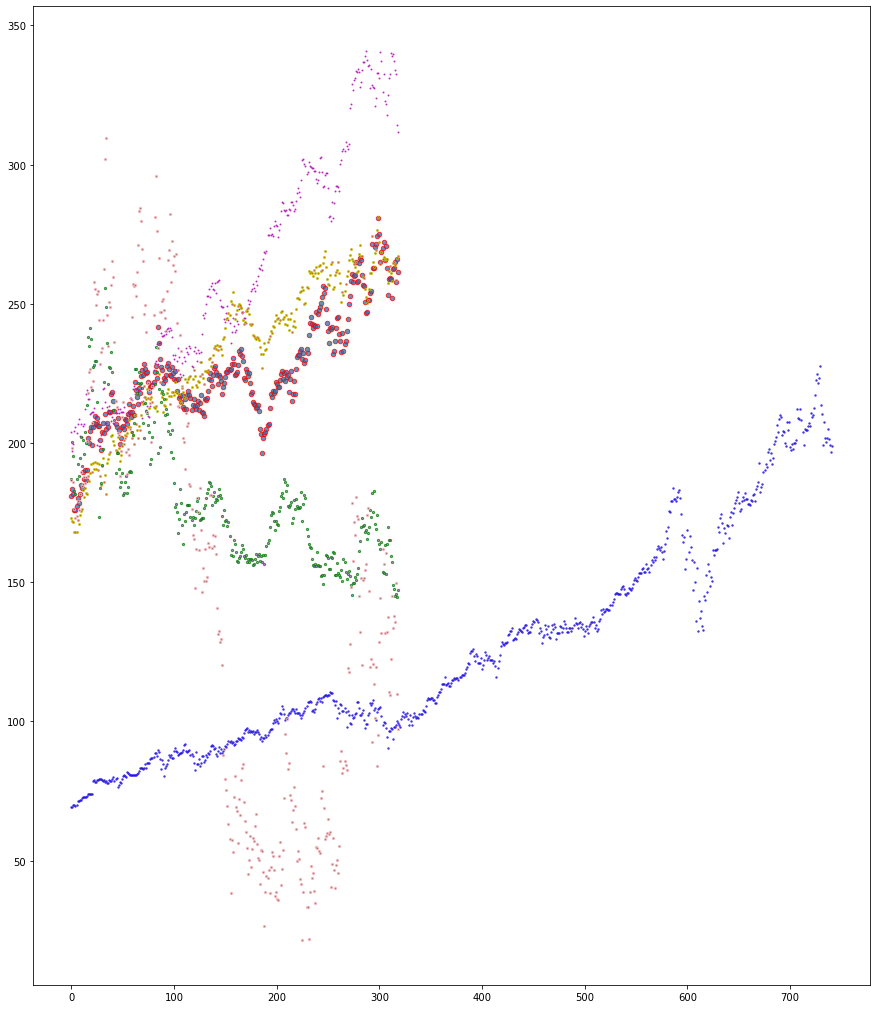

In [440]:
#Best params:  {'C': 100, 'degree': 2, 'epsilon': 5, 'gamma': 0.1, 'kernel': 'rbf'}
n_clusters=np.unique(Y_test)
kmeans = KMeans(n_clusters= n_clusters.size, random_state=0)
clusters_test = kmeans.fit_predict(X_test)
### y_train
n_clusters=np.unique(Y_train)
kmeans = KMeans(n_clusters= n_clusters.size, random_state=0)
clusters_train = kmeans.fit_predict(X_train)
### LM_pred
Model_LM = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
LM_pred = Model_LM.fit(X_train, Y_train).predict(X_test)

#svr 
c_val = 100
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.1)
svr_poly = SVR(kernel='poly', C=c_val, degree=2)
SVR_Linear = svr_lin.fit(X_train,Y_train).predict(X_test)   #ค่า Linear Rbf Poly
SVR_Rbf     = svr_rbf.fit(X_train,Y_train).predict(X_test)
SVR_Poly = svr_poly.fit(X_train,Y_train).predict(X_test)


plt.figure(figsize =(15, 18))
plt.scatter(np.arange(len(LM_pred)),    LM_pred,         edgecolors='r',     alpha=0.75,s=20)
plt.scatter(np.arange(len(Y_train)),    Y_train,       edgecolors='b',     alpha=0.75,s=2)
plt.scatter(np.arange(len(Y_test)),     Y_test,         edgecolors='m',     alpha=0.75,s=1)
plt.scatter(np.arange(len(SVR_Linear)), SVR_Linear,    edgecolors='y',     alpha=0.75,s=4)
plt.scatter(np.arange(len(SVR_Rbf)),    SVR_Rbf,         edgecolors='g',     alpha=0.75,s=5)
plt.scatter(np.arange(len(SVR_Poly)),   SVR_Poly,       edgecolors='pink',  alpha=0.75,s=6)

plt.show()

In [435]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR

    grid_rand = RandomizedSearchCV( 
                                    estimator=model, 
                                    n_jobs = 8,
                                    verbose = 10,
                                    cv = 5,
                                    scoring = 'neg_mean_squared_error',
                                    param_distributions = params )
    grid_rand_result = grid_rand.fit(X_train, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [436]:
# Show Best Parameters for both models
print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)

Best params:  {'kernel': 'rbf', 'gamma': 0.05500000000000001, 'epsilon': 0.775, 'degree': 2, 'C': 112.525}
Best score:  -842.7005229611477


In [437]:
# Show Score for each parameter combination for both model
means = grid_rand_result.cv_results_['mean_test_score']
stds = grid_rand_result.cv_results_['std_test_score']
params = grid_rand_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-1310.394855 (1808.990162) with: {'kernel': 'linear', 'gamma': 0.05500000000000001, 'epsilon': 0.1, 'degree': 3, 'C': 0.1}
-842.700523 (1147.292947) with: {'kernel': 'rbf', 'gamma': 0.05500000000000001, 'epsilon': 0.775, 'degree': 2, 'C': 112.525}
-988.962187 (1234.421802) with: {'kernel': 'rbf', 'gamma': 0.0325, 'epsilon': 0.55, 'degree': 3, 'C': 37.575}
-1243.361383 (1400.023756) with: {'kernel': 'linear', 'gamma': 0.0775, 'epsilon': 0.55, 'degree': 2, 'C': 75.05}
-1239.301121 (1385.620770) with: {'kernel': 'linear', 'gamma': 0.1, 'epsilon': 0.325, 'degree': 2, 'C': 150.0}
-1245.762564 (1400.255708) with: {'kernel': 'linear', 'gamma': 0.1, 'epsilon': 0.775, 'degree': 3, 'C': 150.0}
-1571.786992 (1617.455067) with: {'kernel': 'poly', 'gamma': 0.05500000000000001, 'epsilon': 1.0, 'degree': 2, 'C': 150.0}
-871.951440 (1194.400873) with: {'kernel': 'rbf', 'gamma': 0.05500000000000001, 'epsilon': 1.0, 'degree': 2, 'C': 75.05}
-1768.546194 (1989.404705) with: {'kernel': 'poly', 'gamma': 0.

## Display Mean, std, params

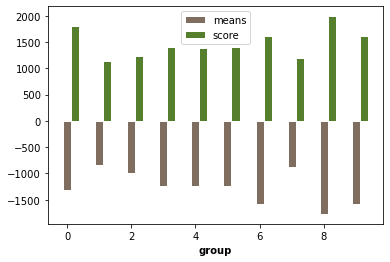

In [439]:
# plt.bar(np.arange(len(means)),means)
# plt.bar(np.arange(len(stds)),stds)
# plt.bar(np.arange(len(params)),params)

# set width of bars
barWidth = 0.25
 
 
# Set position of bar on X axis
r1 = np.arange(len(means))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, means, color='#7f6d5f', width=barWidth, edgecolor='white', label='means')
plt.bar(r2, stds, color='#557f2d', width=barWidth, edgecolor='white', label='score')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
#plt.xticks([r + barWidth for r in range(len(means))], ['A', 'B', 'C', 'D', 'E'])
 
# Create legend & Show graphic
plt.legend()
plt.show()



## Show scatter plot compare y_test vs each model prediction